In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import os, re, random, shutil, pathlib
import numpy as np
import tensorflow as tf
import keras
from sklearn.metrics import f1_score
from collections import Counter
from matplotlib import pyplot as plt

tf.random.set_seed(0)
np.random.seed(0)


In [3]:
# ---------- 1·dossier ----------
DATA_DIR = pathlib.Path("/content/drive/MyDrive/Traitement automatique des langues/dataset")
TRAIN_DIR, DEV_DIR, TEST_DIR = DATA_DIR/"train", DATA_DIR/"dev", DATA_DIR/"test"
PRED_DIR = DATA_DIR/"pred"; PRED_DIR.mkdir(exist_ok=True)

# if not DEV_DIR.exists() or not any(DEV_DIR.iterdir()):
#     DEV_DIR.mkdir(exist_ok=True)
#     files = sorted(TRAIN_DIR.glob("*.txt")); random.shuffle(files)
#     for f in files[: int(0.1*len(files))]:
#         shutil.move(str(f), DEV_DIR/f.name)


In [4]:

# ---------- 2·découpage de phrases ----------
CH_PUNCTS = "，。、：；？！「」"
SENT_SPLIT = re.compile("[。？！；]")

def strip_punct(s): return re.sub(f"[{CH_PUNCTS}]", "", s)

def read(folder, with_punct=True):
    src, tgt = [], []
    for fp in sorted(folder.glob("*.txt")):
        txt = fp.read_text(encoding="utf-8").strip()
        if not txt: continue
        for seg in filter(None, SENT_SPLIT.split(txt)):
            if with_punct:
                src.append(strip_punct(seg)) # source = phrase sans ponct
                tgt.append(seg) # # cible  = phrase originale
            else:
                src.append(seg); tgt.append("")
    return src, tgt

train_src, train_tgt = read(TRAIN_DIR, True)
dev_src,   dev_tgt   = read(DEV_DIR,   True)
test_src,  _         = read(TEST_DIR,  False)


In [5]:

# ---------- 3·TextVectorization ----------
tv = keras.layers.TextVectorization(
        standardize=None, split="character",
        output_mode="int", output_sequence_length=128-2) # 2 places pour <bos>/<eos>, pour définir le début et la fin d'une phrase

tv.adapt([*train_src, *train_tgt, *dev_src, *dev_tgt]) # apprentissage du vocabulaire
PAD = 0
bos_id = tv.vocabulary_size() # on ajoute <bos>
eos_id = bos_id + 1 # on ajoute <eos>
VOCAB = bos_id + 2  # taille totale du vocabulaire

def vec_list(texts): return tv(np.array(texts)).numpy()

def build_pairs(src, tgt):
    x_enc = vec_list(src)             #encodage source
    y     = vec_list(tgt)             #cible brute
    bos = np.full((len(y),1), bos_id)
    eos = np.full((len(y),1), eos_id)
    dec_in  = np.concatenate([bos, y], axis=1)
    dec_out = np.concatenate([y, eos], axis=1)
    mask    = (dec_out != PAD).astype("float32") # 0 sur PAD
    return x_enc, dec_in, dec_out, mask

enc_tr, din_tr, dout_tr, m_tr = build_pairs(train_src, train_tgt)
enc_dev,din_dev,dout_dev,m_dev = build_pairs(dev_src,  dev_tgt)
enc_te  = vec_list(test_src)


In [ ]:
# ───────────────────────────── 4. MODÈLE ─────────────────────────────────────
EMB = 256
HID = 256
emb = keras.layers.Embedding(VOCAB, EMB, mask_zero=True, name="emb")

# ---- Encodeur ---------
enc_in = keras.Input((None,), dtype="int32", name="encoder")
x = emb(enc_in)
x = keras.layers.Bidirectional(
        keras.layers.GRU(HID, return_sequences=True), name="enc_gru")(x)
enc_seq = keras.layers.LayerNormalization(name="enc_norm")(x)

# ---- Decodeur -------
dec_in = keras.Input((None,), dtype="int32", name="decoder_in")
y = emb(dec_in)
y = keras.layers.GRU(HID*2, return_sequences=True,
                     dropout=0.2, name="dec_gru")(y)   # dropout interne

# ---- Attention ----------
score   = keras.layers.Dot(axes=[2,2])([y, enc_seq])            # (B,Tdec,Tenc)
attn    = keras.layers.Softmax(axis=-1, name="attention")(score)
context = keras.layers.Dot(axes=[2,1])([attn, enc_seq])         # (B,Tdec,H)
context = keras.layers.Dropout(0.2)(context)

# ---- Projection finale -----------------------------------------------------
dec_cat = keras.layers.Concatenate()([y, context])
dec_cat = keras.layers.LayerNormalization()(dec_cat)
logits  = keras.layers.Dense(VOCAB, activation="softmax",
                             name="classif")(dec_cat)

model = keras.Model([enc_in, dec_in], logits, name="PuncGen")
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()],
              weighted_metrics=[])

model.summary()


Model: "PuncGen"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_in          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, None, 256) │  1,246,208 │ encoder[0][0],    │
│                     │                   │            │ decoder_in[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ decoder_in[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_gru             │ (None, None, 512) │    789,504 │ emb[0][0],        │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_gru (GRU)       │ (None, None, 512) │  1,182,720 │ emb[1][0],        │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_norm            │ (None, None, 512) │      1,024 │ enc_gru[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, None,      │          0 │ dec_gru[0][0],    │
│                     │ None)             │            │ enc_norm[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention (Softmax) │ (None, None,      │          0 │ dot[0][0]         │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, None, 512) │          0 │ attention[0][0],  │
│                     │                   │            │ enc_norm[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 512) │          0 │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ dec_gru[0][0],    │
│ (Concatenate)       │ 1024)             │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None,      │      2,048 │ concatenate[0][0] │
│ (LayerNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classif (Dense)     │ (None, None,      │  4,989,700 │ layer_normalizat… │
│                     │ 4868)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,211,204 (31.32 MB)

 Trainable params: 8,211,204 (31.32 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ─────────────────────────── 5. ENTRAÎNEMENT ────────────────────────────────
history = model.fit([enc_tr, din_tr], dout_tr, sample_weight=m_tr,
          validation_data=([enc_dev, din_dev], dout_dev, m_dev),
          batch_size=64, epochs=20, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(patience=4,
                                                   restore_best_weights=True)])

Epoch 1/20
260/260 - 42s - 162ms/step - loss: 0.5468 - sparse_categorical_accuracy: 0.0943 - val_loss: 0.1157 - val_sparse_categorical_accuracy: 0.1534
Epoch 2/20
260/260 - 36s - 139ms/step - loss: 0.0594 - sparse_categorical_accuracy: 0.1625 - val_loss: 0.0516 - val_sparse_categorical_accuracy: 0.1635
Epoch 3/20
260/260 - 42s - 161ms/step - loss: 0.0328 - sparse_categorical_accuracy: 0.1682 - val_loss: 0.0456 - val_sparse_categorical_accuracy: 0.1652
Epoch 4/20
260/260 - 41s - 159ms/step - loss: 0.0257 - sparse_categorical_accuracy: 0.1705 - val_loss: 0.0423 - val_sparse_categorical_accuracy: 0.1664
Epoch 5/20
260/260 - 41s - 156ms/step - loss: 0.0220 - sparse_categorical_accuracy: 0.1718 - val_loss: 0.0397 - val_sparse_categorical_accuracy: 0.1673
Epoch 6/20
260/260 - 41s - 158ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.1728 - val_loss: 0.0381 - val_sparse_categorical_accuracy: 0.1679
Epoch 7/20
260/260 - 42s - 160ms/step - loss: 0.0168 - sparse_categorical_accuracy: 0.17

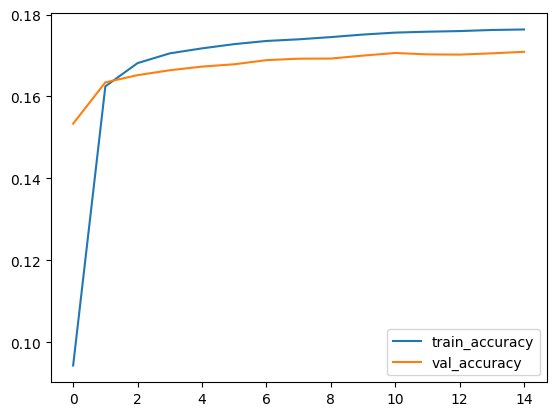

In [8]:
plt.plot(history.history["sparse_categorical_accuracy"], label="train_accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

Une remarque pas importante, sur ma propre machine avec CPU, la sparse accuracy est assez haute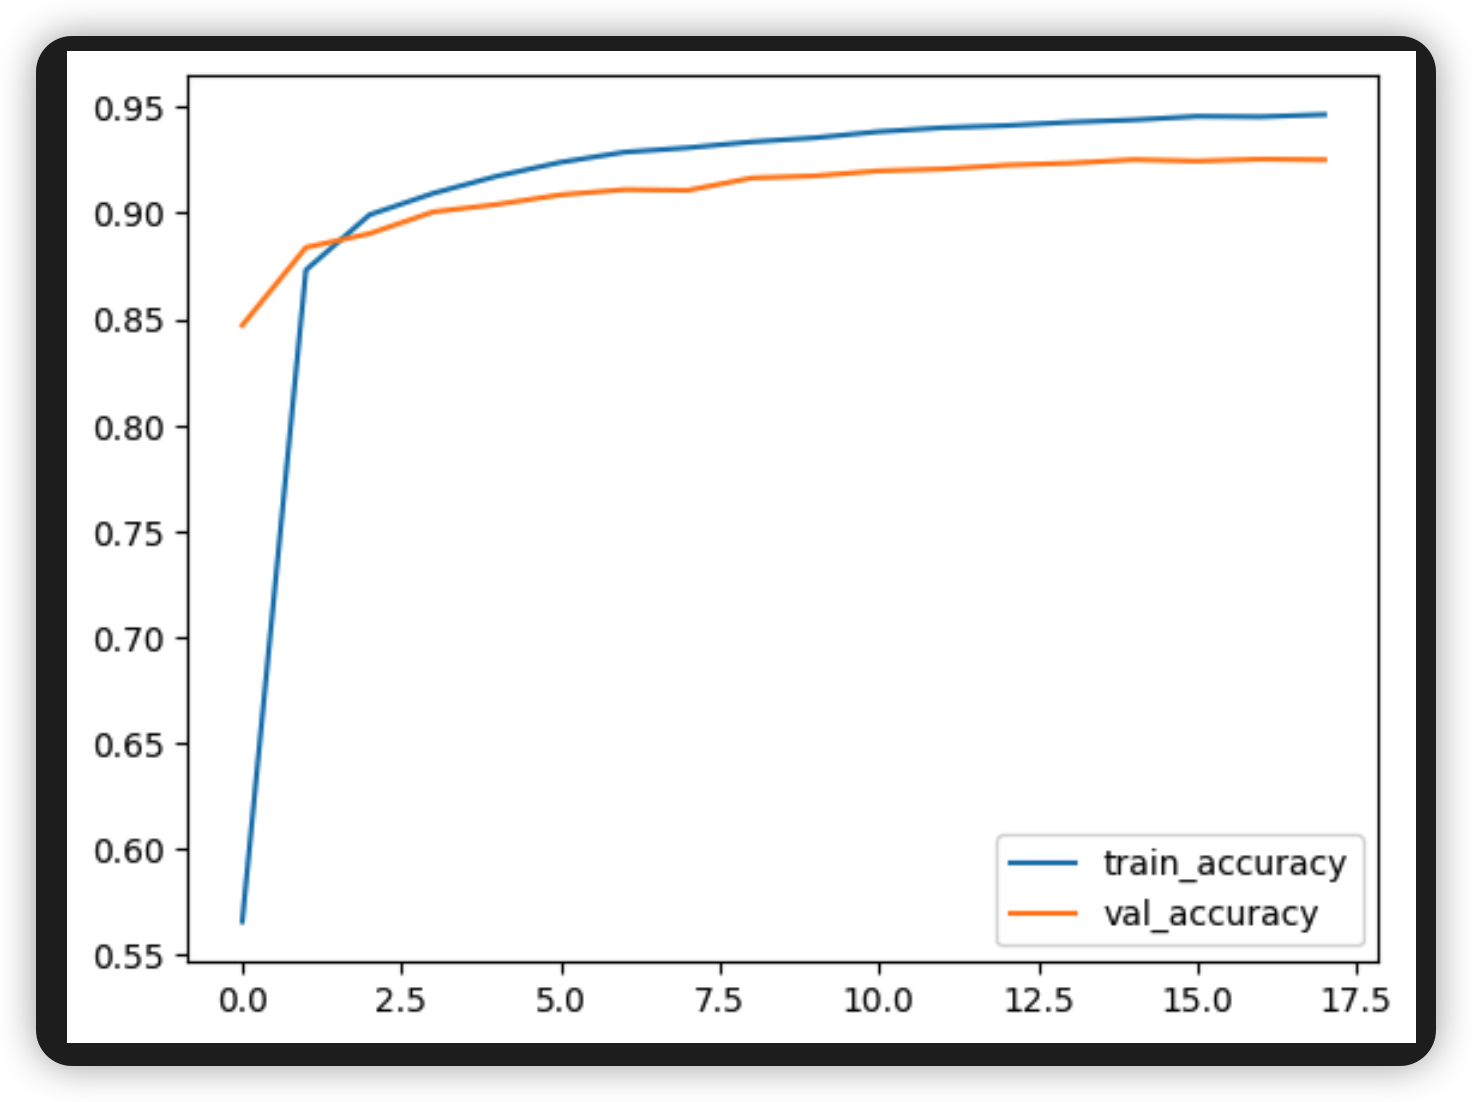

In [9]:
# ---------- 6·Éval F1-score ----------
def macro_f1(pred):
    pred = pred.argmax(-1)
    yt, yp = [], []
    for t,p,m in zip(dout_dev, pred, m_dev.astype(bool)):
        yt.extend(t[m]); yp.extend(p[m])
    return f1_score(yt, yp, average="macro", zero_division=0)

def batched_f1(batch=32):
    yt, yp = [], []
    for i in range(0, len(enc_dev), batch):
        prob = model.predict([enc_dev[i:i+batch],
                              din_dev[i:i+batch]], batch_size=batch, verbose=0)
        pred = prob.argmax(-1)
        m    = m_dev[i:i+batch].astype(bool)
        for t, p, mask in zip(dout_dev[i:i+batch], pred, m):
            yt.extend(t[mask]); yp.extend(p[mask])
    return f1_score(yt, yp, average="macro", zero_division=0)

print("Dev macro-F1:", batched_f1(16))


Dev macro-F1: 0.9246693567914813


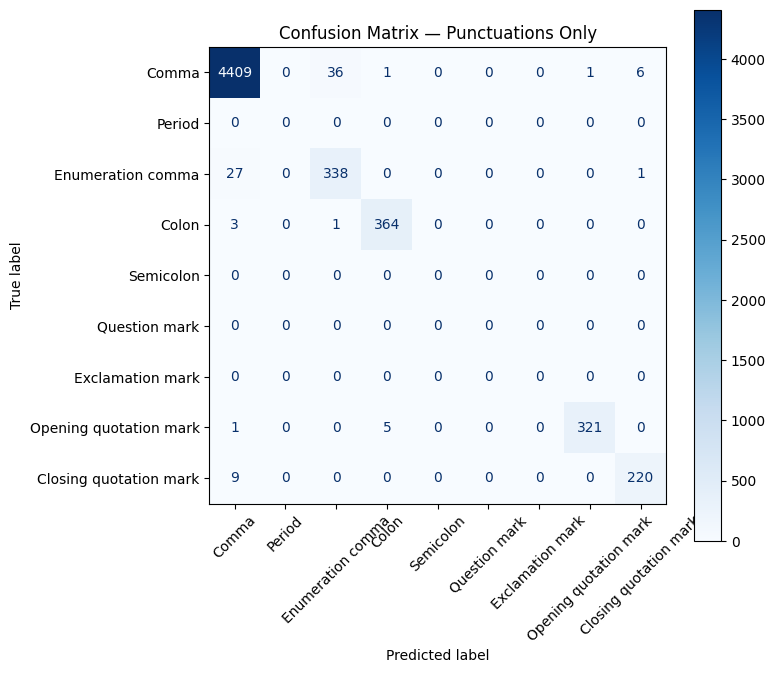

In [23]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

batch = 32
preds = []
for i in range(0, len(enc_dev), batch):
    logits = model.predict([enc_dev[i:i+batch], din_dev[i:i+batch]],
                           batch_size=batch, verbose=0)
    preds.append(logits.argmax(-1))
pred_dev = np.concatenate(preds, axis=0)

mask_bool   = m_dev.astype(bool)
y_true_flat = dout_dev[mask_bool]
y_pred_flat = pred_dev[mask_bool]


puncts = "，。、：；？！「」"
punct_ids = {p: tv([p]).numpy()[0][0] for p in puncts}   # dict char → id

punct_english_names = {
    "，": "Comma",
    "。": "Period",
    "、": "Enumeration comma",
    "：": "Colon",
    "；": "Semicolon",
    "？": "Question mark",
    "！": "Exclamation mark",
    "「": "Opening quotation mark",
    "」": "Closing quotation mark"
}


punct_list  = list(puncts)                               # ['，','。', …]
punct_id_ls = [punct_ids[p] for p in punct_list]         # [id_，, id_。 ...]


display_labels = [punct_english_names[p] for p in punct_list]


keep_mask = np.isin(y_true_flat, punct_id_ls)
y_true_p  = y_true_flat[keep_mask]
y_pred_p  = y_pred_flat[keep_mask]


cm = confusion_matrix(y_true_p, y_pred_p, labels=punct_id_ls)


fig, ax = plt.subplots(figsize=(8, 7))
disp = ConfusionMatrixDisplay(cm, display_labels=display_labels)
disp.plot(include_values=True, cmap="Blues",
          ax=ax, xticks_rotation=45, colorbar=True)

plt.title("Confusion Matrix — Punctuations Only")
plt.tight_layout()
plt.show()

In [11]:
# ───────────────── Generator utilitaire ──────────────────
from keras_hub.samplers import Sampler, GreedySampler, TopKSampler, TopPSampler

class Generator:
    """
    TopKSampler / TopPSampler / RandomSampler
    """
    def __init__(self, model, sampler: Sampler = None):
        self.model   = model
        self.sampler = sampler or GreedySampler()   # par défault argmax


        self.bos_id  = globals()["bos_id"]
        self.eos_id  = globals()["eos_id"]

        self.idx2tok = tv.get_vocabulary() + ["<bos>", "<eos>"]

    def _step(self, enc_tok, dec_tok):
        prob = self.model(
            [enc_tok, dec_tok], training=False)
        return prob[:, -1, :]                       # On prend le dernier


    def generate(self, raw_sent, max_len=128):
        enc = tv([strip_punct(raw_sent)])
        dec = [self.bos_id]

        for _ in range(max_len):
            logits = self._step(enc, tf.constant([dec]))
            nxt = self.sampler.get_next_token(logits)[0].numpy()
            if nxt == self.eos_id:
                break
            dec.append(int(nxt))
        return "".join(self.idx2tok[i] for i in dec[1:])

# ───────────────── Sample test ─────────────────

gen_greedy = Generator(model)                      # argmax
gen_topk   = Generator(model, TopKSampler(k=5))
gen_topp   = Generator(model, TopPSampler(p=0.9))



In [12]:
sent = "忠表薦及第尋爲裴樞宣諭判官至汴州全忠復表薦之既而文圭投"

print("Greedy :", gen_greedy.generate(sent))
print()

print("Top-k  :", gen_topk.generate(sent))
print()

print("Top-p  :", gen_topp.generate(sent))

Greedy : 忠表薦及第，尋爲裴樞宣諭，判官至汴州，全忠復表薦之，既而文圭投投第，尋爲裴樞宣諭判官，至汴州，全忠復表薦之，既而文圭投投第，尋爲裴樞宣諭判官，至汴州，全忠復表薦之，既而文圭投汴州，全忠復表薦之，既而文圭投投第，尋爲裴樞宣諭判官，至汴州，全忠復表薦之，既而文

Top-k  : 忠表薦及第，尋爲裴樞宣諭判官，至汴州，所忠復文圭投之，既而文圭投汴，之既而文圭投汴州，全忠復表薦之，既而文圭投投第，尋爲裴樞宣諭判官，至汴州，全忠復表薦之，既而文圭投之，既而文圭投投第，尋爲裴樞宣諭，判官至汴州，全忠復表薦之，既而文圭投之，既而文圭投汴州，

Top-p  : 忠表薦及第，尋爲裴樞宣諭判官，至汴州，全忠復表薦之，既而文圭投之，既而文圭投汴州，全忠復表薦之，既而文圭投之，既而文圭投汴州，全忠復表薦之，既而文圭投投第，尋爲裴樞宣諭判官，至汴州，全忠復表薦之，既而文圭投投第，尋爲裴樞宣諭判官，至汴州，全忠復表薦之，既而


In [13]:
!pip install keras-tuner

In [14]:
import keras_tuner as kt
import tensorflow as tf, keras

# ─── fonction constructeur flexible ────────────────────────────
def build_model_hp(hp: kt.HyperParameters):
    VOCAB = globals()["VOCAB"]             # récupère de l'espace global
    PAD   = 0

    # hyper-paramètres à explorer
    emb_dim   = hp.Int("emb_dim", 128, 512, step=128)
    hid_enc   = hp.Int("hid_enc", 128, 512, step=128)

    hid_dec   = hid_enc * 2
    n_dec     = hp.Int("n_dec_layers", 1, 2)
    dr_embed  = hp.Float("drop_embed", 0.0, 0.3, step=0.1)
    dr_rnn    = hp.Float("drop_rnn",   0.0, 0.5, step=0.1)
    lr        = hp.Choice("lr", [1e-3, 5e-4, 1e-4])

    emb = keras.layers.Embedding(VOCAB, emb_dim, mask_zero=True)

    # ─ encoder ─
    enc_in = keras.Input((None,), name="enc")
    x = emb(enc_in)
    x = keras.layers.SpatialDropout1D(dr_embed)(x)
    x = keras.layers.Bidirectional(
            keras.layers.GRU(hid_enc, return_sequences=True,
                             dropout=dr_rnn))(x)
    enc_seq = keras.layers.LayerNormalization()(x) # Shape: (None, None, hid_enc * 2)

    # ─ decoder ─
    dec_in = keras.Input((None,), name="dec_in")
    y = emb(dec_in)
    for _ in range(n_dec):
        y = keras.layers.GRU(hid_dec, return_sequences=True,
                             dropout=dr_rnn)(y) # Shape: (None, None, hid_dec) = (None, None, hid_enc * 2)

    score   = keras.layers.Dot(axes=[2,2])([y, enc_seq])
    attn    = keras.layers.Softmax(axis=-1)(score)
    ctx     = keras.layers.Dot(axes=[2,1])([attn, enc_seq])
    out     = keras.layers.Concatenate()([y, ctx])
    out     = keras.layers.LayerNormalization()(out)

    logits  = keras.layers.Dense(VOCAB, activation="softmax")(out)
    model   = keras.Model([enc_in, dec_in], logits)


    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss=loss,
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

# ─── préparation des données miniatures pour le tuning rapide ─
#   (prendre 5 % pour explorer vite)
Nsub = int(len(enc_tr)*.05)
x_enc_sub, x_dec_sub = enc_tr[:Nsub], din_tr[:Nsub]
y_sub,     m_sub     = dout_tr[:Nsub], m_tr[:Nsub]

# ─── définition du tuner ───────────────────────────────────────
tuner = kt.RandomSearch(
    build_model_hp,
    objective=kt.Objective("val_sparse_categorical_accuracy", "max"),
    max_trials=20,
    executions_per_trial=1,
    directory="kt_logs",
    project_name="punc_gen")

tuner.search_space_summary()

tuner.search([x_enc_sub, x_dec_sub], y_sub,
             sample_weight=m_sub,
             validation_split=0.2,
             batch_size=32,
             epochs=10,
             callbacks=[keras.callbacks.EarlyStopping(patience=2)])

best_hp   = tuner.get_best_hyperparameters(1)[0]
print("Meilleur hyper-paramètres :", best_hp.values)



Search space summary
Default search space size: 6
emb_dim (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
hid_enc (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
n_dec_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
drop_embed (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
drop_rnn (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |emb_dim
256               |256               |hid_enc
1                 |1                 |n_dec_layers
0.1             

KeyboardInterrupt: 

In [ ]:
# ─── ré-entraîner le meilleur modèle sur full-data ─────────────
best_model = tuner.hypermodel.build(best_hp)
best_model.fit([enc_tr, din_tr], dout_tr, sample_weight=m_tr,
               validation_data=([enc_dev, din_dev], dout_dev, m_dev),
               batch_size=64, epochs=20,
               callbacks=[keras.callbacks.EarlyStopping(patience=4,
                                    restore_best_weights=True)])